In [251]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [252]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_august.csv", sep=",")

In [253]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
0,1/31/2008,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
1,2/29/2008,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
2,3/31/2008,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,...,0.0,NaN,0.0,NaN,2.6,0.000,NaN,5.25,0.000000,NaN
3,4/30/2008,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,...,0.0,NaN,0.0,NaN,2.7,0.033,NaN,5.31,0.020000,NaN
4,5/31/2008,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,...,0.0,NaN,0.0,NaN,2.8,0.067,NaN,5.50,0.083333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667
211,8/31/2025,26.9,15.2,21.7,6.3,6.2,4.4,4.6,3.8,6.0,...,0.0,0.0,0.0,0.0,4.0,0.000,0.000000,4.25,-0.083333,-0.041667


In [254]:
ex_future=df[df['Ap'].isna()][['Mnd',
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
        'Rodt_skandale_lag6',
        'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
        #'Frp_reg_lag6','SV_reg_lag6', 
        #'SP_reg_lag6','KrF_reg_lag6',
        #'Venstre_reg_lag6', 
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]

In [255]:
ex_future
ex_future["Mnd"] = pd.to_datetime(df["Mnd"])
ex_future.set_index("Mnd", inplace=True)

In [256]:
df.dropna(inplace=True)

In [257]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
5,6/30/2008,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
6,7/31/2008,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
7,8/31/2008,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
8,9/30/2008,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
9,10/31/2008,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,4/30/2025,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667


In [258]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [259]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [260]:
df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,4.5,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [261]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df_en = df_en.diff().dropna()  # Difference to make stationary
df_orig=df

In [262]:
df_ex=df[[
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
       #'Venstre_skandale_lag6', 
        #'MDG_skandale_lag6', 
       'Rodt_skandale_lag6',
       #'Andre_skandale_lag6', 
       # 'Ap_reg', 'Hoyre_reg', 'Frp_reg', 'SV_reg',
       #'SP_reg', 'KrF_reg', 'Venstre_reg', 'MDG_reg', 'Rodt_reg', 'Andre_reg',
       #'Ap_reg_lag3', 
       'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
       # 'Frp_reg_lag6','SV_reg_lag6', 
       # 'SP_reg_lag6','KrF_reg_lag6',
       # 'Venstre_reg_lag6', 
        #'MDG_reg_lag6',
        #'Rodt_reg_lag6', 
        #'Andre_reg_lag6',
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]

In [263]:
df_ex

,Ap_skandale_lag6,Hoyre_skandale_lag6,Frp_skandale_lag6,SV_skandale_lag6,SP_skandale_lag6,KrF_skandale_lag6,Rodt_skandale_lag6,Ap_reg_lag6,Hoyre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,
2008-07-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
2008-11-30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.000,0.033333,4.75,-0.333333,-0.131667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [264]:
#model = VARMAX(endog=df_en, exog=df_ex, order=(6,0), trend='c')
#model_fitted = model.fit(disp=False)

#print(model_fitted.summary())

In [265]:
model = VAR(endog=df_en, exog=df_ex)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [266]:
model_fitted = model.fit(maxlags=1,method = 'ols', trend='n', verbose=True)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Aug, 2025
Time:                     12:36:50
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -8.62610
Nobs:                     205.000    HQIC:                  -11.0394
Log likelihood:          -1359.27    FPE:                3.15555e-06
AIC:                     -12.6785    Det(Omega_mle):     9.98471e-07
--------------------------------------------------------------------
Results for equation Ap
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
Ap_skandale_lag6            -0.184168         0.219421           -0.839           0.401
Hoyre_skandale_lag6          0.021659         0.238686            0.091           0.928
Frp_skandale_lag6            0.1770

In [267]:
# Compute R² for each party
r2_scores = {}
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']:
    r2_scores[party] = r2_score(df_en[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.1700
R² for Hoyre: 0.1644
R² for Frp: 0.1085
R² for SV: 0.2208
R² for SP: 0.1293
R² for KrF: 0.2856
R² for Venstre: 0.2108
R² for MDG: 0.1698
R² for Rodt: 0.2121
R² for Andre: 0.1481


In [268]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [269]:
all_fitted= model_fitted.fittedvalues

In [270]:
all_fitted

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-08-31,-0.437993,-0.361701,0.409063,0.098508,0.250866,0.027377,0.039824,0.068485,-0.028808,-0.240756
2008-09-30,0.929648,-0.777940,-0.284330,0.021906,-0.007133,0.274088,-0.324460,0.089824,0.008344,-0.043529
2008-10-31,0.914465,-0.776808,-0.211050,0.248976,0.066368,-0.124889,0.098212,-0.002910,-0.179202,-0.096518
2008-11-30,0.830133,0.310661,-0.553773,-0.130172,-0.403233,0.226281,0.142782,-0.178661,-0.364009,-0.134653
2008-12-31,0.184564,1.194322,-0.379008,0.074831,-0.258472,-0.332288,-0.190362,-0.027106,-0.466893,-0.232030
...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.525306,-0.923358,-0.039825,-0.274283,0.655585,0.212544,0.114941,-0.067662,0.107602,-0.238087
2025-05-31,0.341642,-0.572132,0.131796,0.280113,-0.080702,-0.020116,0.128914,-0.123350,-0.001502,-0.055210
2025-06-30,0.396068,-0.196457,0.151984,-0.516888,0.247237,0.051132,-0.134798,0.176616,-0.199659,-0.066687


In [271]:
steps = 1  # Number of steps to forecast
alpha = 0.1

forecast, lower, upper = model_fitted.forecast_interval(df_en.values[-model_fitted.k_ar:],  exog_future=ex_future, steps=steps, alpha=alpha)


In [272]:
forecast

array([[-0.24519693, -0.50229939,  0.3678628 ,  0.67832777,  0.39182097,
        -0.64616681,  0.01176888,  0.09835124,  0.12433928, -0.36094984]])

In [273]:
forecast_dates = pd.date_range(start="2025-09-30", periods=steps, freq='ME')

last_actual_value = df_orig.iloc[-1]  # Last known actual data point

forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en.columns)
forecast_lower_df=pd.DataFrame(lower, index=forecast_dates, columns=df_en.columns)
forecast_upper_df=pd.DataFrame(upper, index=forecast_dates, columns=df_en.columns)

forecast_df = forecast_df.cumsum() + last_actual_value
forecast_lower_df = forecast_lower_df.cumsum() + last_actual_value
forecast_upper_df = forecast_upper_df.cumsum() + last_actual_value

In [274]:
# Get forecast covariance in differenced scale
forecast_cov = model_fitted.forecast_cov(steps=steps)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov[t] = np.sum(forecast_cov[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_df = {t: pd.DataFrame(forecast_cov[t], index=df_en.columns, columns=df_en.columns)
                            for t in range(steps)}

In [275]:
df_en=df_orig

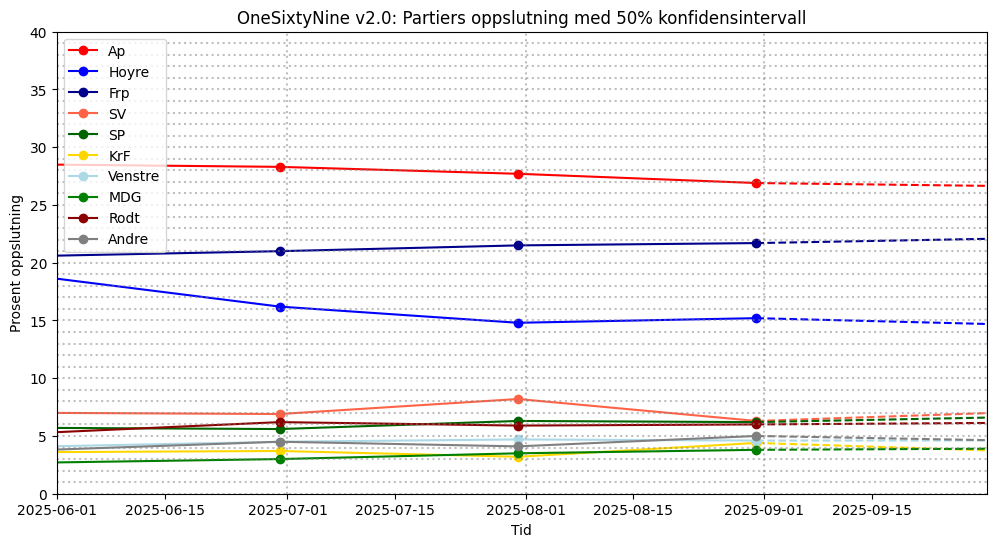

In [276]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df_en.index, df_en[party], marker="o", color=color, label=f"{party}")

    # Plot forecast 
    plt.plot(forecast_df.index, forecast_df[party], linestyle="dashed", color=color)

    last_actual_date = df_en.index[-1]
    first_forecast_date = forecast_df.index[0]
    last_actual_value = df_en[party].iloc[-1]
    first_forecast_value = forecast_df[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_df.index, 
                     forecast_lower_df[party], 
                     forecast_upper_df[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS") 
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2025-06-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v2.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [277]:
forecast_df=forecast_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_df=(forecast_df.T / forecast_df.sum(axis=1) * 100).T
forecast_lower_df=forecast_lower_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_upper_df=forecast_upper_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

In [278]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_df.loc[date_to_extract]
lower_row = forecast_lower_df.loc[date_to_extract]
upper_row = forecast_upper_df.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
result_df

,Party,Estimate,Lower,Upper
0,Ap,26.650044,24.297971,29.011635
1,Hoyre,14.695076,12.649737,16.745665
2,Frp,22.063923,20.145904,23.989822
3,SV,6.977082,6.220708,7.735947
4,SP,6.590644,5.117345,8.066297
5,KrF,3.753163,3.160223,4.347443
6,Venstre,4.610945,3.940240,5.283298
7,MDG,3.897655,3.341510,4.455193
8,Rodt,6.123246,5.383624,6.865055
9,Andre,4.638222,3.987650,5.290450


In [279]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov[-1]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.9640


In [280]:
sampled_df

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
0,25.885289,15.674226,21.905482,6.626906,5.938130,3.927459,4.371085,3.622305,6.893386,5.155732
1,25.362959,15.117423,22.825466,6.747016,6.110743,3.422977,4.510375,4.456610,6.167700,5.278732
2,26.722960,15.122132,21.544482,7.228650,6.357963,3.909673,4.274118,3.943523,5.922718,4.973780
3,26.664818,15.593772,21.641831,7.173281,5.965785,3.729879,4.843371,3.843813,6.062452,4.480998
4,23.391641,15.853639,23.958763,7.633709,5.964208,3.888416,5.692774,3.475563,6.306907,3.834380
...,...,...,...,...,...,...,...,...,...,...
999995,24.070599,14.516128,23.303486,7.080655,6.376010,3.842483,5.605673,4.140365,6.383718,4.680884
999996,25.714732,13.777141,21.929242,7.155632,7.558782,3.314690,5.248716,4.457804,5.587331,5.255931
999997,25.587533,13.878247,22.673265,7.342433,7.117617,3.419200,4.608523,3.981040,6.623024,4.769119
999998,29.018127,12.342818,22.817839,7.076778,7.029779,3.216137,4.629270,3.740292,6.177198,3.951761


In [281]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [282]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [283]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [284]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [285]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
0,47,28,40,12,11,3,8,3,12
1,46,27,41,12,11,3,8,8,11
2,48,27,39,13,12,3,8,3,11
3,48,28,39,13,11,3,9,3,11
4,42,29,43,14,11,3,10,3,11
...,...,...,...,...,...,...,...,...,...
999995,44,26,42,13,12,3,10,8,12
999996,47,25,40,13,14,3,10,8,10
999997,46,25,41,13,13,3,8,3,12
999998,53,22,41,13,13,3,8,3,11


In [286]:
sample_mandate['Sum']=sample_mandate.sum(axis=1)

In [287]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
0,47,28,40,12,11,3,8,3,12,164
1,46,27,41,12,11,3,8,8,11,167
2,48,27,39,13,12,3,8,3,11,164
3,48,28,39,13,11,3,9,3,11,165
4,42,29,43,14,11,3,10,3,11,166
...,...,...,...,...,...,...,...,...,...,...
999995,44,26,42,13,12,3,10,8,12,170
999996,47,25,40,13,14,3,10,8,10,170
999997,46,25,41,13,13,3,8,3,12,164
999998,53,22,41,13,13,3,8,3,11,167


In [288]:
sample_169=sample_mandate[sample_mandate["Sum"]==169].copy()

In [289]:
sample_169

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
34,47,29,41,12,12,3,8,7,10,169
37,49,24,40,13,11,8,10,3,11,169
58,49,21,42,12,14,7,9,3,12,169
64,49,23,42,13,10,7,10,3,12,169
70,47,27,42,12,12,8,9,3,9,169
...,...,...,...,...,...,...,...,...,...,...
999975,44,26,41,13,15,3,9,7,11,169
999978,47,27,38,12,14,3,9,8,11,169
999982,48,23,42,13,13,3,8,7,12,169
999985,46,24,40,13,15,3,9,8,11,169


In [290]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "SP"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "SP", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [291]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [292]:
sample_169['r_avh'] = (sample_169['ap_sp_sv'] < 85) & (sample_169['ap_sp_sv_r']) >= 85

In [293]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())
print(sample_169['r_avh'].mean())

0.924695320357333
0.0
7.395136957936461e-06
0.37241909720168015
0.924695320357333
0.0
0.07530467964266699
0.6275809027983198
0.0


In [294]:
sample_169.to_csv('sample.csv')

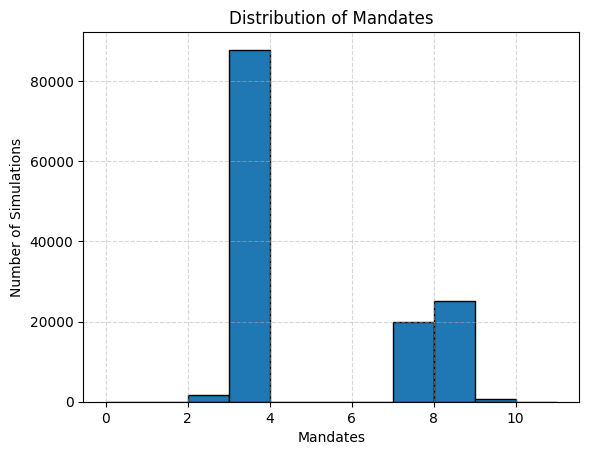

In [295]:
import matplotlib.pyplot as plt

plt.hist(sample_169['KrF'], bins=range(0, sample_169['KrF'].max() + 2), edgecolor='black')
plt.title('Distribution of Mandates')
plt.xlabel('Mandates')
plt.ylabel('Number of Simulations')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [296]:
last_actual_value

5.0

In [297]:
last_fact=df_orig[df_orig.index=='2025-08-31'][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]

In [298]:
last_fact

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2025-08-31,26.9,15.2,21.7,6.3,6.2,4.4,4.6,3.8,6.0


In [299]:
last_mandate=pd.DataFrame(columns=last_fact.columns)

In [300]:
for party in last_fact.columns:
    last_mandate[party]=last_fact[party].apply(calc_mandat)

In [301]:
last_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2025-08-31,49,28,39,11,11,8,8,3,11


In [302]:
last_mandate['Sum']=last_mandate.sum(axis=1)

In [303]:
last_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
Mnd,,,,,,,,,,
2025-08-31,49,28,39,11,11,8,8,3,11,168


In [305]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
2025-09-30,26.650044,14.695076,22.063923,6.977082,6.590644,3.753163,4.610945,3.897655,6.123246,4.638222


In [306]:
forecast_df['Sum']=forecast_df.sum(axis=1)

In [307]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,Sum
2025-09-30,26.650044,14.695076,22.063923,6.977082,6.590644,3.753163,4.610945,3.897655,6.123246,4.638222,100.0
